# Exercise 4: recommender System

In [1]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [2]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [3]:
def getTopN(movie_id,N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [4]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [5]:
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [12]:
D2 = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
D2=np.abs(np.nan_to_num( D2-1)) #dist to similarity 
np.fill_diagonal(D2,0) #set self-dist to zero

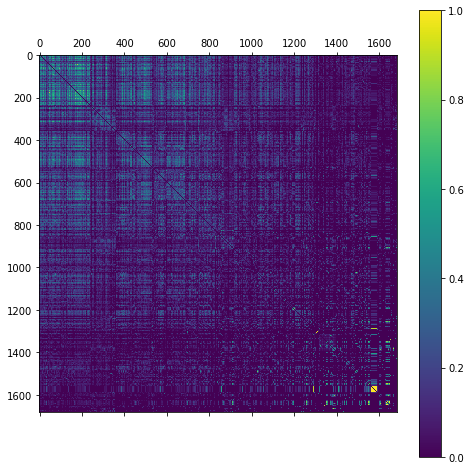

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D)
plt.colorbar()

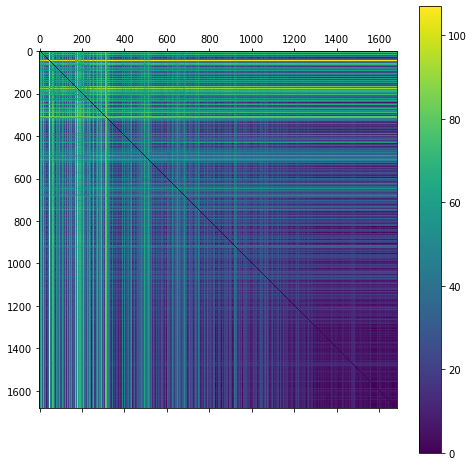

In [13]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D2)
plt.colorbar()

## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [247]:
import random

def getRandomMovie(Da, N=5):
    rand = random.randint(0,Da.shape[1]-1)
    randomMovies = Da[rand,:].argsort()[-1::]
    for i in range(N-1):
        rand = random.randint(0,Da.shape[1]-1)
        randomMovies = np.append(randomMovies,Da[rand,:].argsort()[-1::])
    
    return randomMovies

def CIIRandom(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getRandomMovie(D))
    else:
        print ("no movie title containing " + str(title) + "found...")

def getTopNOverAllUsers(Da, N=5):
    cols = np.sum(Da, axis=1) / Da.shape[0]
    maxIds = cols.argsort()[-N:][::-1]
    return maxIds

def CIITop(D,title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopNOverAllUsers(D))
    else:
        print ("no movie title containing " + str(title) + "found...")
        

In [248]:
CIIRandom("Titanic")

recommending movies for: 'Titanic (1997)'


1669                            Tainted (1998)
81                        Jurassic Park (1993)
1562    Promise, The (Versprechen, Das) (1994)
143                            Die Hard (1988)
187                   Full Metal Jacket (1987)
Name: title, dtype: object

In [249]:
CIITop(D, "Titanic")

recommending movies for: 'Titanic (1997)'


203          Back to the Future (1985)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
55                 Pulp Fiction (1994)
78                Fugitive, The (1993)
Name: title, dtype: object

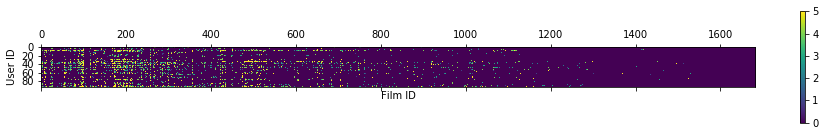

In [250]:
#split into train and test data
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)
plt.matshow(R_test)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()

In [251]:
D_train=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
D_train=np.abs(np.nan_to_num( D_train-1))

In [252]:
#Anfrage auf dem Trainingsdatensatz
CIIRandom("Titanic")

recommending movies for: 'Titanic (1997)'


1649                           Butcher Boy, The (1998)
404                         Mission: Impossible (1996)
927                                  Craft, The (1996)
1265    Bread and Chocolate (Pane e cioccolata) (1973)
577                              Demolition Man (1993)
Name: title, dtype: object

In [253]:
CIITop(D, "Titanic")

recommending movies for: 'Titanic (1997)'


203          Back to the Future (1985)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
55                 Pulp Fiction (1994)
78                Fugitive, The (1993)
Name: title, dtype: object

In [254]:
def Score_byRandom(D, Test):
    res_id = getRandomMovie(D)
    res_title = getNameByID(getRandomMovie(D))
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
def test_ScoreRandom(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byRandom(D_train,R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

def Score_byTop(D, Test):
    res_id = getTopNOverAllUsers(D)
    res_title = getNameByID(getTopNOverAllUsers(D))
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
def test_ScoreTop(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byTop(D_train,R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [255]:
Score_byRandom(D_train, R_test[23])

(array([1239,  745,   57,  162, 1539], dtype=int64),
 1463                  Stars Fell on Henrietta, The (1995)
 1213    In the Realm of the Senses (Ai no corrida) (1976)
 441                          Amityville Curse, The (1990)
 133                                   Citizen Kane (1941)
 1185                                  Inkwell, The (1994)
 Name: title, dtype: object,
 array([0., 0., 0., 0., 0.]),
 0.0)

In [256]:
Score_byTop(D_train, R_test[23])

(array([203, 173, 171,  55, 422], dtype=int64),
 203            Back to the Future (1985)
 173       Raiders of the Lost Ark (1981)
 171      Empire Strikes Back, The (1980)
 55                   Pulp Fiction (1994)
 422    E.T. the Extra-Terrestrial (1982)
 Name: title, dtype: object,
 array([0., 0., 3., 0., 0.]),
 0.6)

In [257]:
test_resRandom=test_ScoreRandom(D_train,R_test)
test_resTop=test_ScoreTop(D_train,R_test)

(array([37., 18., 11.,  9.,  9.,  2.,  3.,  3.,  1.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

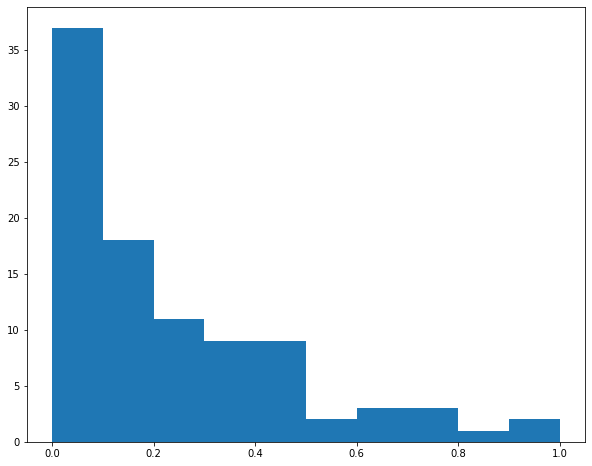

In [259]:
plt.hist(test_resRandom)

(array([33.,  5.,  6.,  3.,  8.,  5., 14., 11.,  6.,  4.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

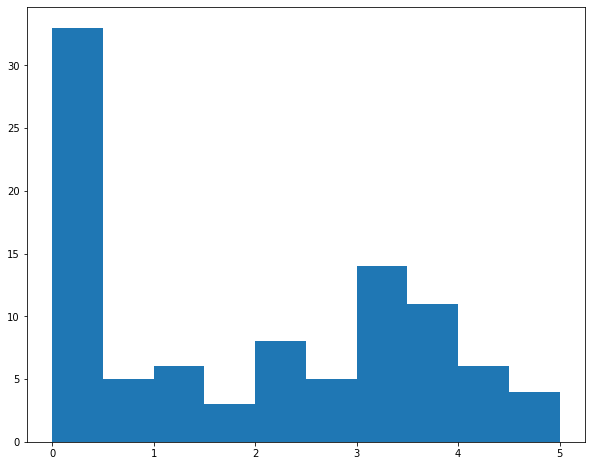

In [260]:
plt.hist(test_resTop)

In [261]:
np.mean(test_resRandom)

0.2122105263157895

In [262]:
np.mean(test_resTop)

1.863157894736842

In [ ]:
## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$


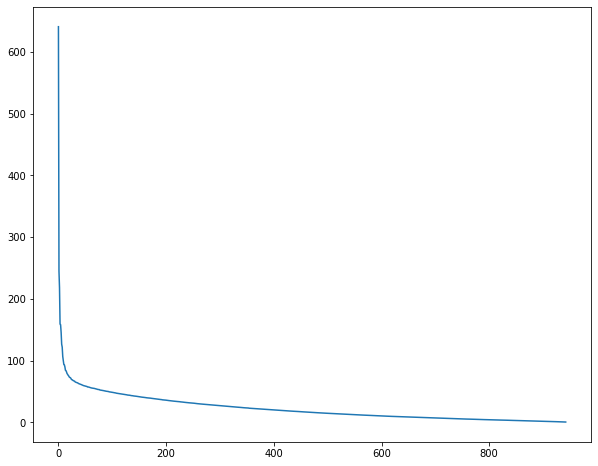

In [272]:
u, s, vh = np.linalg.svd(R)
plt.plot(s)
#cut off at around 400
cutoff=400
reconstructedR = np.dot(u[:,:cutoff]*s[:cutoff],vh[:cutoff,:])

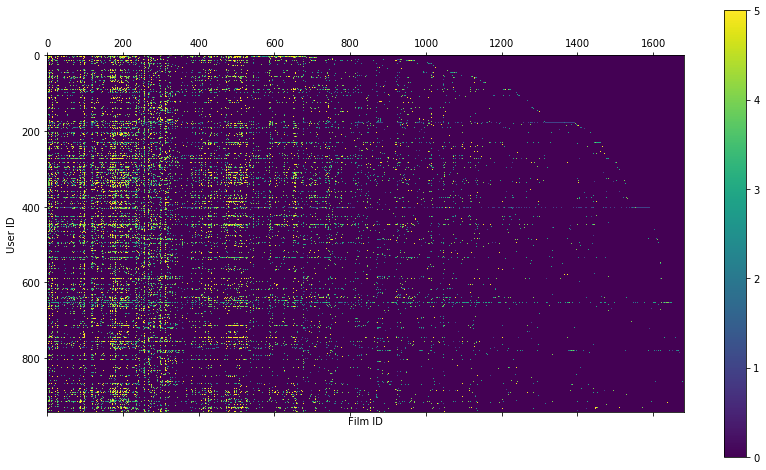

In [265]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
#show matrix    
plt.matshow(R)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()

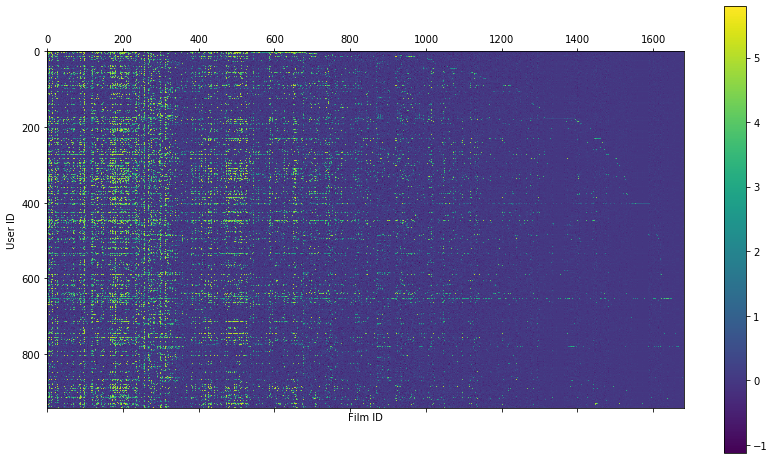

In [273]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
#show matrix    
plt.matshow(reconstructedR)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()

In [276]:
D3=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(reconstructedR.T, metric='cosine'))
D3=np.abs(np.nan_to_num( D3-1)) #dist to similarity 
np.fill_diagonal(D3,0) #set self-dist to zero

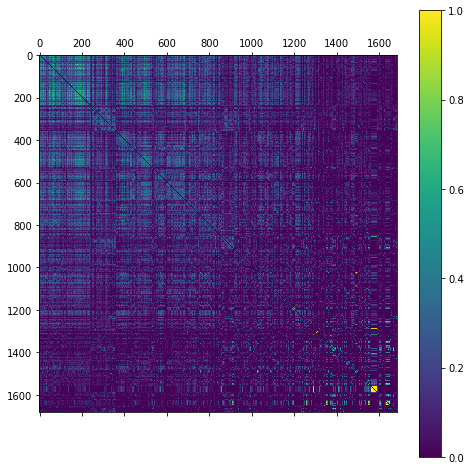

In [277]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D3)
plt.colorbar()